In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np 
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
from sklearn.utils import resample
from sklearn import preprocessing

%matplotlib inline

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

import spacy

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Exploring the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/data2.csv')
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
callers = df['Caller'].unique() 
print("No of callers: {0} \nCallers list: {1}".format(callers.shape, callers))
df['Description'].fillna(value=' ', inplace=True)

No of callers: (2950,) 
Callers list: ['spxjnwir pjlcoqds' 'hmjdrvpb komuaywn' 'eylqgodm ybqkwiam' ...
 'bjitvswa yrmugfnq' 'oybwdsgx oxyhwrfz' 'kqvbrspl jyzoklfx']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8498 non-null   object
 1   Description        8500 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


### Visualizing data

* Find the no of clusters for each of the clusters
* Group clusters that have very few messages(less than 10) into 1
* Display the type of messages for the top 5 clusters
* Drop caller and short description as caller contains gibberish data and short description is not useful as detailed description is available

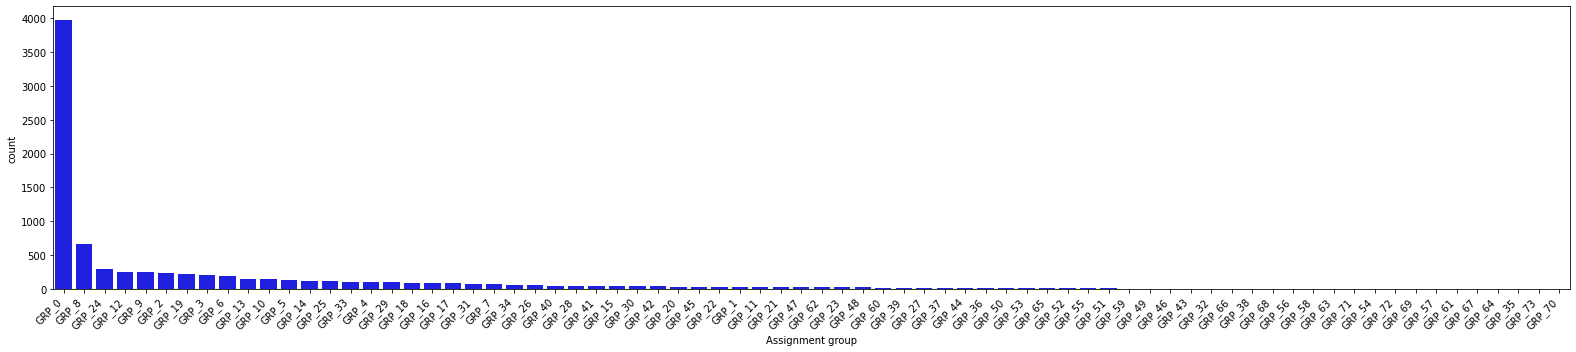

In [ ]:
no_of_clusters = df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize = (22,5))
ax = sns.countplot(x = 'Assignment group', data = df, color = 'blue', order = no_of_clusters)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

Found 25 groups which have under 10 samples
After regrouping: 


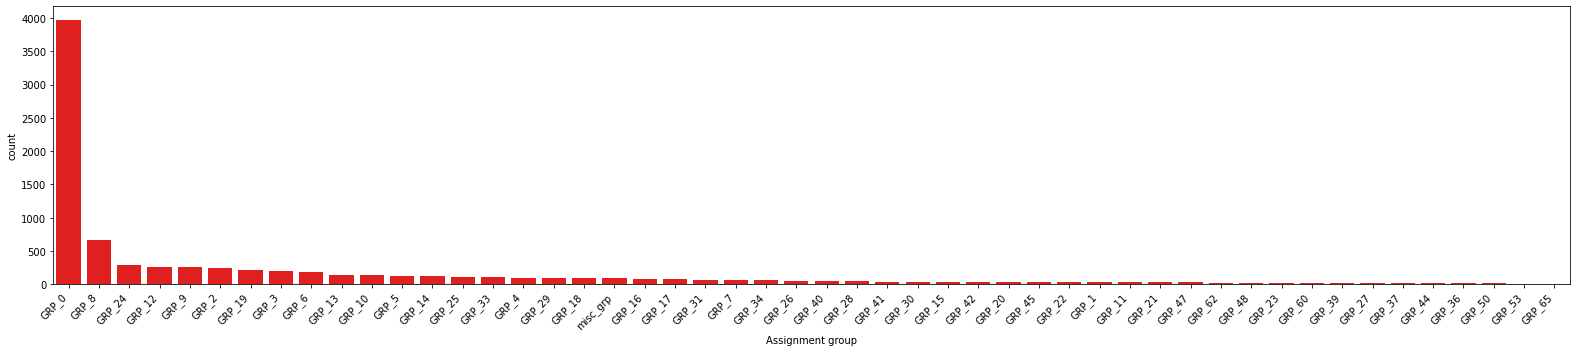

In [ ]:
sample = df.groupby(['Assignment group'])
regroup=[]
for grp in df['Assignment group'].unique():
    if(sample.get_group(grp).shape[0]<10):
        regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
df['Assignment group']=df['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

print('After regrouping: ')
no_of_clusters = df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize = (22,5))
ax = sns.countplot(x = 'Assignment group', data = df, color = 'red', order = no_of_clusters)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

In [ ]:
no_of_clusters
for i in range(0,5,1):
    cluster_ID = no_of_clusters[i]
    for j in range(len(df)):
        if(df.iloc[j]['Assignment group'] == cluster_ID):
            print("Group ID: {0}, Type of message: {1}\n".format(cluster_ID, df.iloc[j]['Short description']))
            break

Group ID: GRP_0, Type of message: login issue

Group ID: GRP_8, Type of message: job mm_zscr0099_dly_merktc3 failed in job_scheduler at: 10/31/2016 08:36:00  

Group ID: GRP_24, Type of message: support fÃ¼r fa.gstry \arexjftu ohxdwngl

Group ID: GRP_12, Type of message: amssm00345: c:\ label:sys-amssm00345 94ef9088 on server: is over  85% space consumed. space available: 2.7 g 

Group ID: GRP_9, Type of message: job Job_1338 failed in job_scheduler at: 10/31/2016 02:29:00  



In [ ]:
df.drop(['Caller','Short description'],axis=1,inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8500 non-null   object
 1   Assignment group  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


### Pre-processing

### 1. Cleaning the text

* Convert the text to lower case letters
* Remove email IDs
* Remove numbers
* Remove hyperlinks
* Remove encoded characters

In [ ]:
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def clean_data(text):
    text = text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
        namelist = [part for part in name.split()]
        for namepart in namelist: 
            text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text
  

In [ ]:
df['Cleaned Description'] = df['Description'].apply(clean_data)
print("Sample Description: \n")
print("Before Cleaning: {0}\nAfter Cleaning:  {1}".format(df.iloc[1]['Description'], df.iloc[1]['Cleaned Description']))

Sample Description: 

Before Cleaning: 

received from: hmjdrvpb.komuaywn@gmail.com

hello team,

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind 
After Cleaning:  hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind


In [ ]:
df['Length'] = [len(text) for text in df['Cleaned Description']]
# df = df[df['Length']>=3]
# df['Cleaned Description'] = df['Cleaned Description'].apply(lambda x : " ".join([word for word in x.split() if(len(word)>2)]))

### 2. Remove stopwords

In [ ]:
english_stopwords = stopwords.words('english')
for i in range(len(df)):
    text = df['Cleaned Description'][i]
    new_text_after_stopwords_removal = ""
    for word in text.split(' '):
        if(word not in english_stopwords):
            new_text_after_stopwords_removal += word + " "
    df['Cleaned Description'][i] = new_text_after_stopwords_removal
#     df['Cleaned Description'][i] = " ".join(word for word in text.split(' ') if word not in english_stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.tail()

,Description,Assignment group,Cleaned Description,Length
8495,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,GRP_29,good afternoon receiving emails sent zz mail p...,79
8496,telephony_software issue,GRP_0,telephony software issue,24
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0,vip windows password reset tifpdchb pedxruyf,48
8498,i am unable to access the machine utilities to...,GRP_62,unable access machine utilities finish drawers...,99
8499,an mehreren pc`s lassen sich verschiedene prgr...,misc_grp,mehreren pc lassen sich verschiedene prgramdnt...,76


### Remove rows that contain description in German

In [ ]:
germanwordlist = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwordlist)

germanDescIndex = df[df['Cleaned Description'].str.contains(pattern)].index
print(germanDescIndex)
df.drop(df.index[[germanDescIndex]])

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8414, 8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8499],
           dtype='int64', length=586)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Description,Assignment group,Cleaned Description,Length
0,-verified user details.(employee# & manager na...,GRP_0,verified user details employee manager name ch...,192
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0,hello team meetings skype meetings etc appeari...,134
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,hi cannot log vpn best,28
3,unable to access hr_tool page,GRP_0,unable access hr tool page,29
4,skype error,GRP_0,skype error,11
...,...,...,...,...
8494,tablet needs reimaged due to multiple issues w...,GRP_3,tablet needs reimaged due multiple issues crm ...,62
8495,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,GRP_29,good afternoon receiving emails sent zz mail p...,79
8496,telephony_software issue,GRP_0,telephony software issue,24
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0,vip windows password reset tifpdchb pedxruyf,48


### 3. Lemmatization

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [ ]:
df['Cleaned Description'] = df['Cleaned Description'].apply(lemmatize_text)
df.head()

,Description,Assignment group,Cleaned Description,Length
0,-verified user details.(employee# & manager na...,GRP_0,verify user detail employee manager name check...,192
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0,hello team meeting skype meeting etc appear ou...,134
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,hi can not log vpn best,28
3,unable to access hr_tool page,GRP_0,unable access hr tool page,29
4,skype error,GRP_0,skype error,11


### Resampling imbalanced dataset

* From the visualization, we see that GRP_0 has high no of data (around 4k)


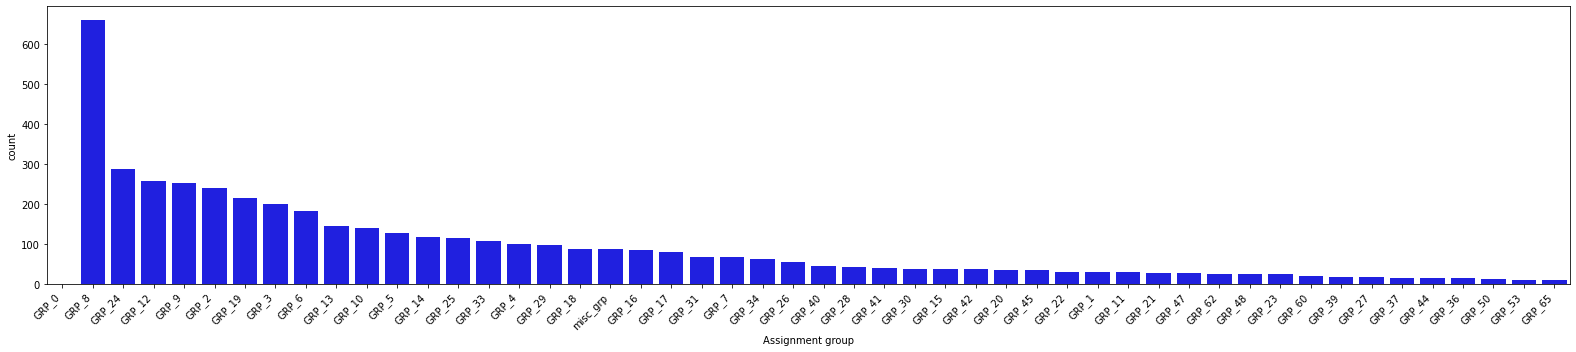

The maximum among other groups other than group 0 is: 661


In [ ]:
# Create Dataset for 'others' i.e all groups which is not part of GRP_0
itTicketOthersDF = df[df['Assignment group'] != 'GRP_0']

descending_order = df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax = sns.countplot(x = 'Assignment group', data = itTicketOthersDF, color = 'blue',order = descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

print("The maximum among other groups other than group 0 is: {0}".format(itTicketOthersDF['Assignment group'].value_counts().max()))


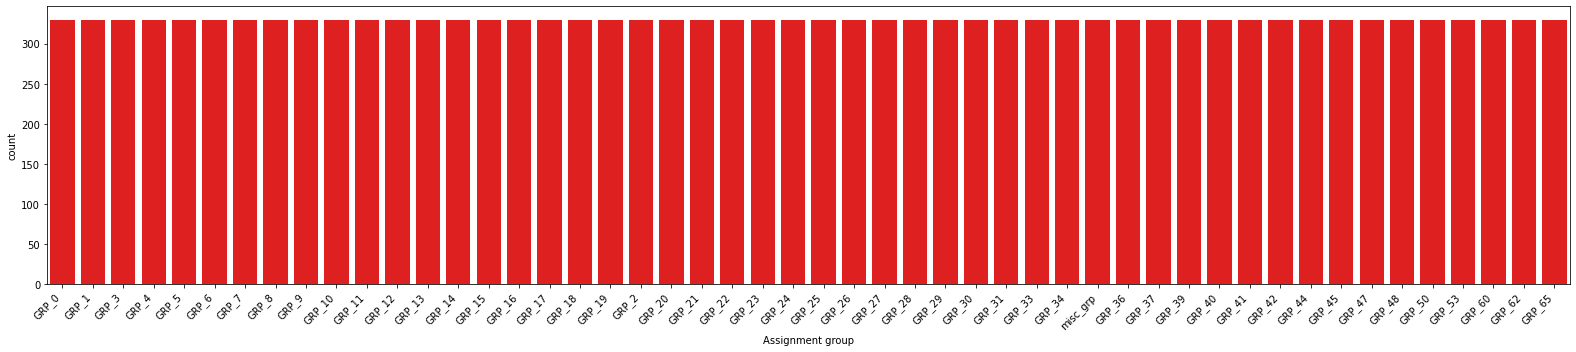

In [ ]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.
df_resampled = df[0:0]
for grp in df['Assignment group'].unique():
    itTicketGrpDF = df[df['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace = True, n_samples = int(661/2), random_state=123)
    df_resampled = df_resampled.append(resampled)

descending_order = df_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize = (22,5))
ax = sns.countplot(x = 'Assignment group', data = df_resampled, color = 'red')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

### Label Encoding

In [ ]:
def labelencoder(dataframe) : 
    label_encoder = preprocessing.LabelEncoder() 
    dataframe= label_encoder.fit_transform(dataframe)
    grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    return dataframe, grp_mapping

df_resampled['Assignment group'] , mapping_df_resampled = labelencoder(df_resampled['Assignment group'])
df['Assignment group'], mapping_df = labelencoder(df['Assignment group'])

print("Mapping for assignment group in original df: {}".format(mapping_df))

Mapping for assignment group in original df: {0: 'GRP_0', 1: 'GRP_1', 2: 'GRP_10', 3: 'GRP_11', 4: 'GRP_12', 5: 'GRP_13', 6: 'GRP_14', 7: 'GRP_15', 8: 'GRP_16', 9: 'GRP_17', 10: 'GRP_18', 11: 'GRP_19', 12: 'GRP_2', 13: 'GRP_20', 14: 'GRP_21', 15: 'GRP_22', 16: 'GRP_23', 17: 'GRP_24', 18: 'GRP_25', 19: 'GRP_26', 20: 'GRP_27', 21: 'GRP_28', 22: 'GRP_29', 23: 'GRP_3', 24: 'GRP_30', 25: 'GRP_31', 26: 'GRP_33', 27: 'GRP_34', 28: 'GRP_36', 29: 'GRP_37', 30: 'GRP_39', 31: 'GRP_4', 32: 'GRP_40', 33: 'GRP_41', 34: 'GRP_42', 35: 'GRP_44', 36: 'GRP_45', 37: 'GRP_47', 38: 'GRP_48', 39: 'GRP_5', 40: 'GRP_50', 41: 'GRP_53', 42: 'GRP_6', 43: 'GRP_60', 44: 'GRP_62', 45: 'GRP_65', 46: 'GRP_7', 47: 'GRP_8', 48: 'GRP_9', 49: 'misc_grp'}


### Tf-Idf Vectorizer

In [ ]:
 X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df['Cleaned Description'], df['Assignment group'], test_size=0.2, random_state=10)
 X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=10)

In [ ]:
print('Training set: {0}, {1}\nValidation set: {2}, {3}\nTest set: {4}, {5}\n'.format(X_train_df.shape, y_train_df.shape, X_val_df.shape, y_val_df.shape, X_test_df.shape, y_test_df.shape))

Training set: (5440,), (5440,)
Validation set: (1360,), (1360,)
Test set: (1700,), (1700,)



In [ ]:
X_train_df = X_train_df.to_frame()
X_test_df = X_test_df.to_frame()
X_val_df = X_val_df.to_frame()

In [ ]:
text_transformer = TfidfVectorizer(ngram_range = (1,2), max_features = 15000)
text_transformer
X_train_tfidf = text_transformer.fit_transform(X_train_df['Cleaned Description']).astype('float16')
X_val_tfidf = text_transformer.fit_transform(X_val_df['Cleaned Description']).astype('float16')
X_test_tfidf = text_transformer.fit_transform(X_test_df['Cleaned Description']).astype('float16')

In [ ]:
print('Train set shape: {0}\nValidation set shape: {1}\nTest set shape: {2}'.format(X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape))

Train set shape: (5440, 15000)
Validation set shape: (1360, 15000)
Test set shape: (1700, 15000)


In [ ]:
LSTM_Tfidf_model = Sequential()
LSTM_Tfidf_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, 15000)))
LSTM_Tfidf_model.add(Dropout(0.3))
LSTM_Tfidf_model.add(Bidirectional(LSTM(256, return_sequences=True)))
LSTM_Tfidf_model.add(Dropout(0.25))
LSTM_Tfidf_model.add(Dense(100, activation='relu'))
LSTM_Tfidf_model.add(Flatten())
LSTM_Tfidf_model.add(Dense(50, activation='softmax'))
  

LSTM_Tfidf_model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
LSTM_Tfidf_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_41 (Bidirecti  (None, 1, 256)           15492096  
 onal)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_42 (Bidirecti  (None, 1, 512)           1050624   
 onal)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 1, 512)            0         
                                                                 
 dense_38 (Dense)            (None, 1, 100)            51300     
                                                                 
 flatten_1 (Flatten)         (None, 100)             

In [ ]:
X_train_tfidf_np = X_train_tfidf.astype(np.float32).A
X_test_tfidf_np = X_test_tfidf.astype(np.float32).A
X_val_tfidf_np = X_val_tfidf.astype(np.float32).A

X_train_tfidf_np = X_train_tfidf_np.reshape(X_train_tfidf_np.shape[0], 1, X_train_tfidf_np.shape[-1])
X_test_tfidf_np = X_test_tfidf_np.reshape(X_test_tfidf_np.shape[0], 1, X_test_tfidf_np.shape[-1])
X_val_tfidf_np = X_val_tfidf_np.reshape(X_val_tfidf_np.shape[0], 1, X_val_tfidf_np.shape[-1])
print('Train set shape: {0}\nValidation set shape: {1}\nTest set shape: {2}'.format(X_train_tfidf_np.shape, X_val_tfidf_np.shape, X_test_tfidf_np.shape))

In [ ]:
y_train_df = y_train_df.to_frame()
y_val_df = y_val_df.to_frame()
y_test_df = y_test_df.to_frame()

y_train_onehot = to_categorical(y_train_df, num_classes = 50)
y_val_onehot = to_categorical(y_val_df, num_classes = 50)
y_test_onehot = to_categorical(y_test_df, num_classes = 50)

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/NLP/' + 'Tfidf-{epoch:03d}-{val_accuracy:03f}.h5', verbose = 1, monitor = 'val_accuracy', save_best_only = True, mode = 'auto') 
reduceLoss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 0.0001)
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
LSTM_Tfidf_model_history = LSTM_Tfidf_model.fit(X_train_tfidf_np, y_train_onehot, batch_size = 128, epochs = epochs, callbacks = [checkpoint, reduceLoss], validation_data = (X_val_tfidf_np, y_val_onehot))

Epoch 1/10
42/43 [============================>.] - ETA: 0s - loss: 1.4501 - accuracy: 0.5763
Epoch 00001: val_accuracy improved from -inf to 0.38235, saving model to /content/drive/MyDrive/NLP/Tfidf-001-0.382353.h5
43/43 [==============================] - 4s 84ms/step - loss: 1.4445 - accuracy: 0.5774 - val_loss: 3.1703 - val_accuracy: 0.3824 - lr: 1.0000e-04
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 1.4193 - accuracy: 0.5816
Epoch 00002: val_accuracy did not improve from 0.38235
43/43 [==============================] - 2s 46ms/step - loss: 1.4193 - accuracy: 0.5816 - val_loss: 3.2056 - val_accuracy: 0.3787 - lr: 1.0000e-04
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 1.3973 - accuracy: 0.5892
Epoch 00003: val_accuracy did not improve from 0.38235
43/43 [==============================] - 2s 42ms/step - loss: 1.3973 - accuracy: 0.5892 - val_loss: 3.2420 - val_accuracy: 0.3779 - lr: 1.0000e-04
Epoch 4/10
43/43 [===========================

In [ ]:
loss, accuracy = LSTM_Tfidf_model.evaluate(X_test_tfidf_np, y_test_onehot, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

54/54 [==============================] - 1s 17ms/step - loss: 3.7164 - accuracy: 0.3476
Test Loss: 3.716400623321533,
Test Accuracy: 0.3476470708847046


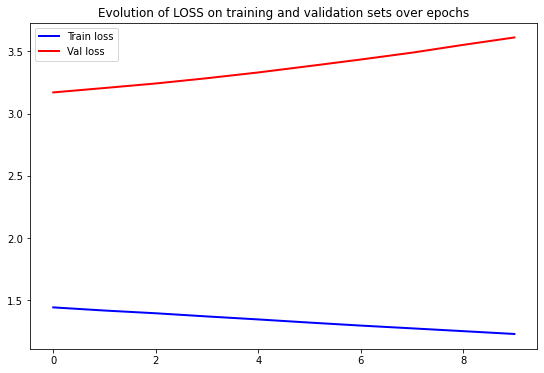

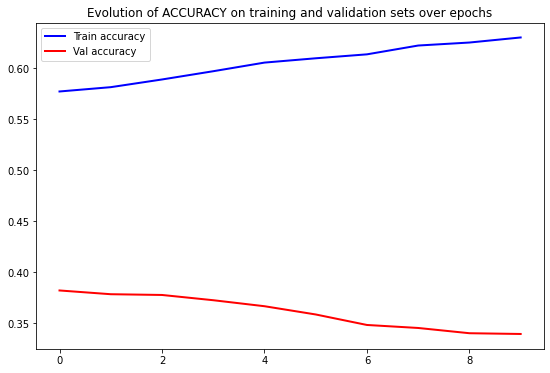

In [ ]:
plot_graph(LSTM_Tfidf_model_history)

### Word2Vec Embeddings

In [ ]:
sentences = [line.split(' ') for line in df['Cleaned Description']]
word2vec = Word2Vec(sentences = sentences, min_count = 1)
word2vec.wv.save_word2vec_format('/content/drive/MyDrive/NLP/word2vec_vector.txt')

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/MyDrive/NLP/word2vec_vector.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 10666 word vectors.


### LSTM Model with Word2Vec Embeddings

In [ ]:
maxlen = 300
numWords = 9000
epochs = 10

In [ ]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words = numWords, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ', char_level = False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer, dataframe

In [ ]:
def tokenizeAndEmbedding(dataframe):
    tokenizer, X = wordTokenizer(dataframe['Cleaned Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
        if i<numWords+1:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    print(embedding_matrix.shape)
    return X, y, embedding_matrix

In [ ]:
def splitData(X, y):
    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))
    print(X_train[0].shape)
    return X_train, X_test, y_train, y_test, X_Val, y_Val

In [ ]:
def fitModel(X_train, y_train, X_Val, y_Val, batch_size, epochs, embedding_matrix, name):
    model = Model()
    input_layer = Input(shape = (maxlen,), dtype = tf.int64)
    print(input_layer.shape)
    embed = Embedding(numWords+1, output_dim = 100, input_length = maxlen, weights = [embedding_matrix], trainable = True)(input_layer)
    lstm = Bidirectional(LSTM(128))(embed)
    drop = Dropout(0.3)(lstm)
    dense = Dense(100, activation = 'relu')(drop)
    out = Dense(len((pd.Series(y_train)).unique()), activation = 'softmax')(dense)   

    model = Model(input_layer, out)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

    model.summary()

    checkpoint = ModelCheckpoint('/content/drive/MyDrive/NLP/' + name + '-{epoch:03d}-{val_accuracy:03f}.h5', verbose = 1, monitor = 'val_accuracy', save_best_only = True, mode = 'auto') 
    reduceLoss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 0.0001)
    earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
    model_history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = [checkpoint, reduceLoss, earlyStopping], validation_data = (X_Val, y_Val))
    return model_history, model

In [ ]:
 def train(dataframe, batch_size, epochs, embedding_matrix, name):
    X, y, embedding_matrix = tokenizeAndEmbedding(dataframe)
    X_train, X_test, y_train,y_test, X_Val, y_Val = splitData(X, y)
    model_history, model = fitModel(X_train, y_train, X_Val, y_Val, batch_size, epochs, embedding_matrix, name)
    return model_history, model, X_test, y_test

In [ ]:
def plot_graph(model):
    epoch_loss = model.history['loss']
    epoch_val_loss = model.history['val_loss']
    epoch_acc = model.history['accuracy']
    epoch_val_acc = model.history['val_accuracy']

    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val loss')
    plt.title('Evolution of LOSS on training and validation sets over epochs')
    plt.legend(loc='best')

    plt.figure(figsize=(20,6))
    plt.subplot(1,2,2)
    plt.plot(range(0, len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train accuracy')
    plt.plot(range(0, len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val accuracy')
    plt.title('Evolution of ACCURACY on training and validation sets over epochs')
    plt.legend(loc='best')

In [ ]:
LSTM_Word2Vec_Raw = Model()
X_test = []
y_test = []
embedding_matrix = []

In [ ]:
LSTM_Word2Vec_Raw_history, LSTM_Word2Vec_Raw, X_test, y_test = train(df, 100, epochs, embedding_matrix, 'LSTM-Word2Vec-Raw')

(9001, 100)
Number of Samples: 8500
Number of Labels:  8500
Number of train Samples: 6800
Number of val Samples: 1700
(300,)
(None, 300)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          900100    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                      

In [ ]:
loss, accuracy = LSTM_Word2Vec_Raw.evaluate(X_test, y_test, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

54/54 [==============================] - 4s 44ms/step - loss: 1.5651 - accuracy: 0.6188
Test Loss: 1.565062165260315,
Test Accuracy: 0.6188235282897949


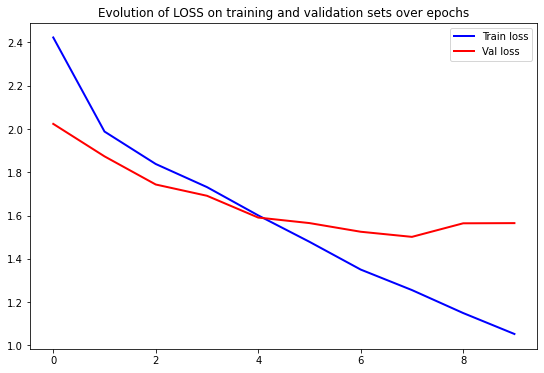

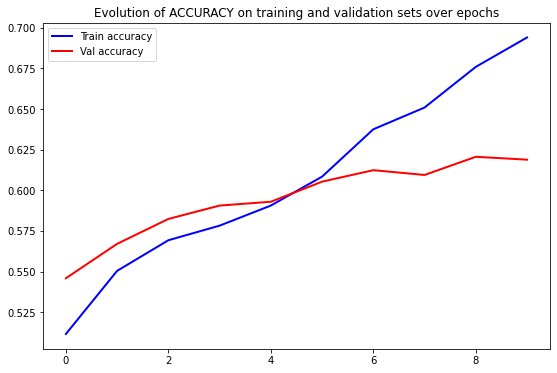

In [ ]:
plot_graph(LSTM_Word2Vec_Raw_history)

### 30 epochs

In [ ]:
LSTM_Word2Vec_Raw_30 = Model()
X_test_30 = []
y_test_30 = []
embedding_matrix = []

In [ ]:
LSTM_Word2Vec_Raw_30_history, LSTM_Word2Vec_Raw_30, X_test_30, y_test_30 = train(df, 100, 30, embedding_matrix, 'LSTM-Word2Vec-Raw-30epochs')

(9001, 100)
Number of Samples: 8500
Number of Labels:  8500
Number of train Samples: 6800
Number of val Samples: 1700
(300,)
(None, 300)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          900100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                      

In [ ]:
loss, accuracy = LSTM_Word2Vec_Raw_30.evaluate(X_test_30, y_test_30, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

54/54 [==============================] - 5s 56ms/step - loss: 1.6644 - accuracy: 0.6082
Test Loss: 1.6644306182861328,
Test Accuracy: 0.6082352995872498


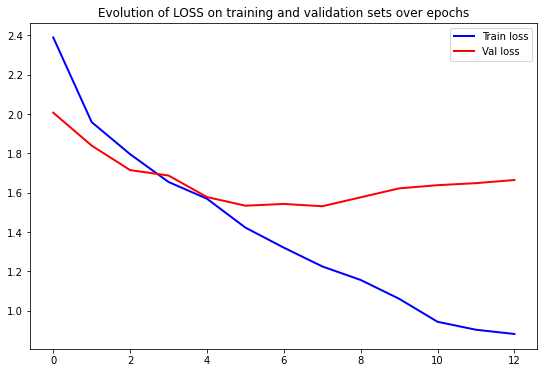

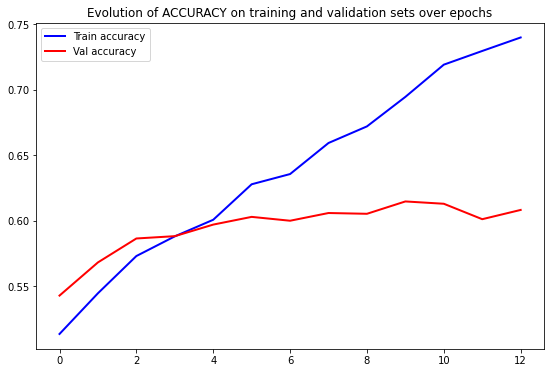

In [ ]:
plot_graph(LSTM_Word2Vec_Raw_30_history)

### Resampled data

In [ ]:
LSTM_Word2Vec_Resampled = Model()
X_test_resampled = []
y_test_resampled = []
embedding_matrix_resampled = []

In [ ]:
LSTM_Word2Vec_Resampled_history, LSTM_Word2Vec_Resampled, X_test_resampled, y_test_resampled = train(df_resampled, 100, 10, embedding_matrix_resampled, 'LSTM_Word2Vec_Resampled')

(9001, 100)
Number of Samples: 16500
Number of Labels:  16500
Number of train Samples: 13200
Number of val Samples: 3300
(300,)
(None, 300)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 300, 100)          900100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               25700     
                                                   

In [ ]:
loss, accuracy = LSTM_Word2Vec_Resampled.evaluate(X_test_resampled, y_test_resampled, verbose = 1)
print("For resampled data: \nTest Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

104/104 [==============================] - 6s 40ms/step - loss: 0.5105 - accuracy: 0.8479
For resampled data: 
Test Loss: 0.5105292201042175,
Test Accuracy: 0.8478788137435913


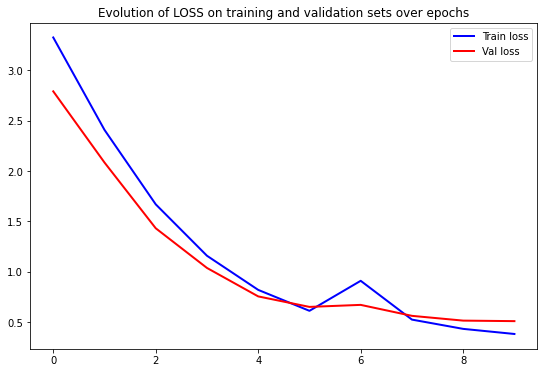

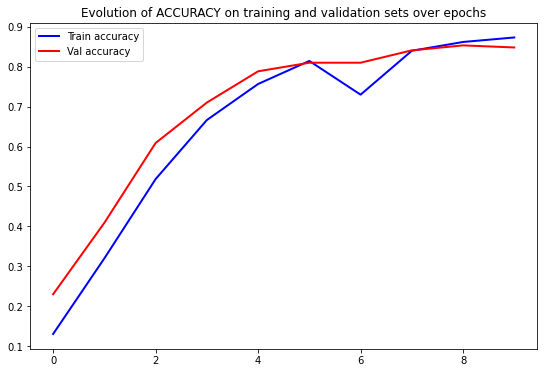

In [ ]:
plot_graph(LSTM_Word2Vec_Resampled_history)

### Resampled - 30 epochs

In [ ]:
LSTM_Word2Vec_Resampled_30 = Model()
X_test_resampled_30 = []
y_test_resampled_30 = []
embedding_matrix_resampled_30 = []

In [ ]:
LSTM_Word2Vec_Resampled_30_history, LSTM_Word2Vec_Resampled_30, X_test_resampled_30, y_test_resampled_30 = train(df_resampled, 100, 30, embedding_matrix_resampled_30, 'LSTM-Word2Vec-Resampled-30epochs')

(9001, 100)
Number of Samples: 16500
Number of Labels:  16500
Number of train Samples: 13200
Number of val Samples: 3300
(300,)
(None, 300)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 100)          900100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               25700     
                                                  

In [ ]:
loss, accuracy = LSTM_Word2Vec_Resampled_30.evaluate(X_test_resampled_30, y_test_resampled_30, verbose = 1)
print("Test Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy))

104/104 [==============================] - 7s 52ms/step - loss: 0.4576 - accuracy: 0.8842
Test Loss: 0.45755133032798767,
Test Accuracy: 0.8842424154281616


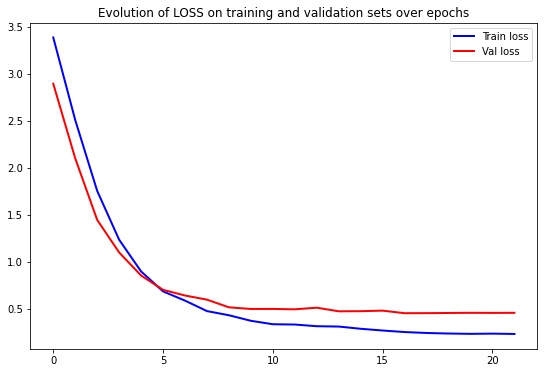

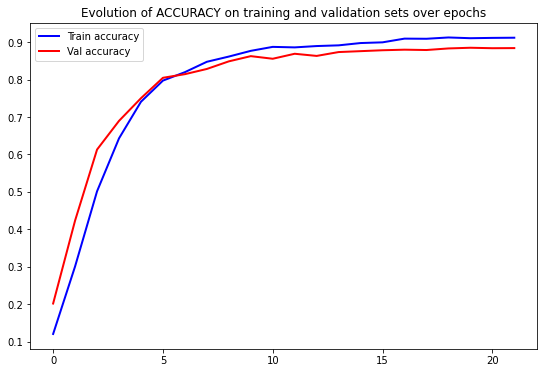

In [ ]:
plot_graph(LSTM_Word2Vec_Resampled_30_history)

In [ ]:
df

,Description,Assignment group,Cleaned Description,Length
0,-verified user details.(employee# & manager na...,0,verify user detail employee manager name check...,192
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,0,hello team meeting skype meeting etc appear ou...,134
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,0,hi can not log vpn best,28
3,unable to access hr_tool page,0,unable access hr tool page,29
4,skype error,0,skype error,11
...,...,...,...,...
8495,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,22,good afternoon receive email send zz mail plea...,79
8496,telephony_software issue,0,telephony software issue,24
8497,vip2: windows password reset for tifpdchb pedx...,0,vip windows password reset tifpdchb pedxruyf,48
8498,i am unable to access the machine utilities to...,44,unable access machine utility finish drawer ad...,99
